# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

In [13]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/'

fileNames = ["dom.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)


def plot(*args):
    count = len(args)
    fig, ax = plt.subplots(1,count)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    if count==1:
        ax.imshow(args[0], cmap="gray")
    else:
        for i in range(len(ax)):
            ax[i].imshow(args[i], cmap="gray")
    plt.show()

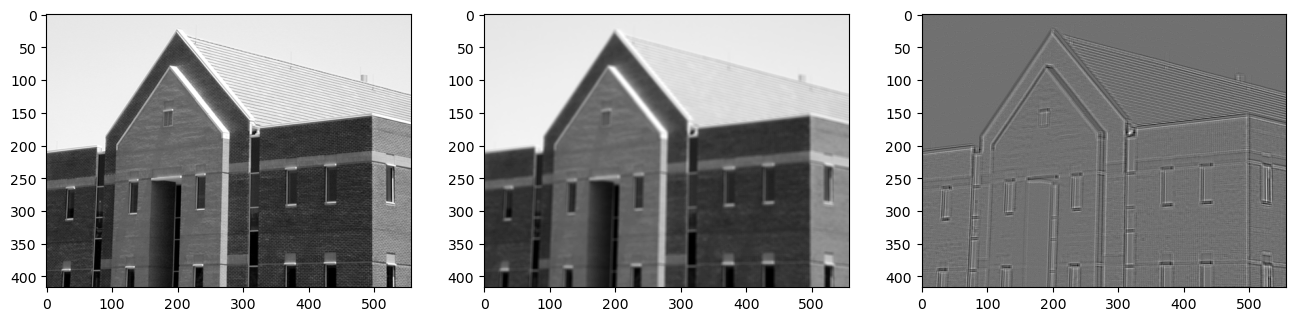

In [2]:
house = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)
houseBlur = cv2.GaussianBlur(house, (5, 5), 15)
houseLaplacian = cv2.Laplacian(houseBlur, cv2.CV_32F)

f, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(house, 'gray')
ax[1].imshow(houseBlur, 'gray')
ax[2].imshow(houseLaplacian, 'gray')
plt.show()

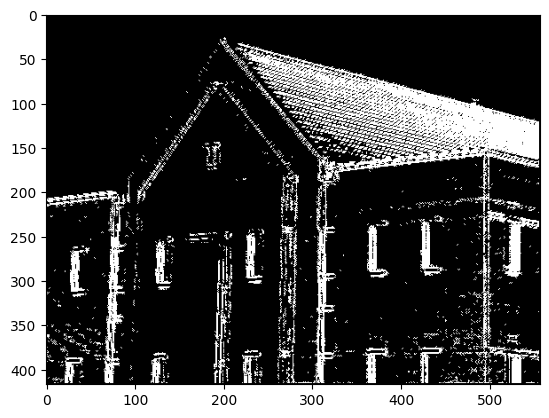

In [17]:

def crossing(img, thr, blurSize):
  out = np.zeros((img.shape))
  size = 3
  for i in range(size//2, img.shape[0] - size//2):
    for j in range(size//2, img.shape[1] - size//2):
      ctx = img[i-size//2:i+size//2+1, j-size//2:j+size//2+1]
      ctxMin = ctx.min()
      ctxMax = ctx.max()
      if ctxMin * ctxMax < 0:
        if img[i, j] > 0:
          out[i, j] = img[i, j] + np.abs(ctxMin)
        else:
          out[i, j] = np.abs(img[i, j]) + ctxMax
      else:
        out[i, j] = img[i, j]

  out = (out / np.max(out)) * 255
  out = np.where(out > thr, 255, 0)
  return cv2.medianBlur(out.astype(np.uint8), blurSize)


outImg = crossing(houseLaplacian, 55, 1)
plt.imshow(outImg, 'gray')

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [4]:
def canny(img):
  imgBlur = cv2.GaussianBlur(img, (5, 5), 3)

  M, alfa = sobel_part(imgBlur)

  gN = nonmax(alfa, M)

  # Th = img.max() * 0.09
  # Tl = Th * 0.05
  Th = 200
  Tl = 100

  gNH = gN >= Th
  gNL = (Th > gN) & (gN >= Tl)

  stack = []
  for i in range(gNH.shape[0]):
    for j in range(gNH.shape[1]):
      if gNH[i, j]:
        stack.append([i, j])

  visited = np.full(img.shape, False)
  outImg = np.zeros(img.shape)

  while stack:
    coords = stack.pop()
    if not visited[coords[0], coords[1]]:
      visited[coords[0], coords[1]] = True
      outImg[coords[0], coords[1]] = 255
      if coords[0] > 0 and coords[0] < gNL.shape[0]-1 and coords[1] > 0 and coords[1] < gNL.shape[1]-1:

        for i in range(coords[0] - 1, coords[0] + 2):
          for j in range(coords[1] - 1, coords[1] + 2):
            if gNL[i, j]:
              stack.append([i, j])

  return outImg, gNH

def nonmax(alfa, img):

  angle = alfa * 180 / np.pi
  angle[alfa < 0] += 180

  outImg = np.zeros(alfa.shape)
  for i in range(1, alfa.shape[0]-1):
    for j in range(1, alfa.shape[1]-1):

      q, r = 255, 255

      if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
        q = img[i, j+1]
        r = img[i, j-1]
      elif (22.5 <= angle[i,j] < 67.5):
        q = img[i+1, j-1]
        r = img[i-1, j+1]
      elif (67.5 <= angle[i,j] < 112.5):
        q = img[i+1, j]
        r = img[i-1, j]
      elif (112.5 <= angle[i,j] < 157.5):
        q = img[i-1, j-1]
        r = img[i+1, j+1]

      if (img[i,j] >= q) and (img[i,j] >= r):
       outImg[i,j] = img[i,j]
      else:
        outImg[i,j] = 0

  return outImg


def sobel_part(img):
  S1 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  S2 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

  gx = cv2.filter2D(img, -1, S1)
  gy = cv2.filter2D(img, -1, S2)

  # M = np.sqrt(gx**2 + gy**2)
  M = np.hypot(gx, gy)
  M = M / M.max() * 255
  alfa = np.arctan2(gy, gx)

  return (M, alfa)



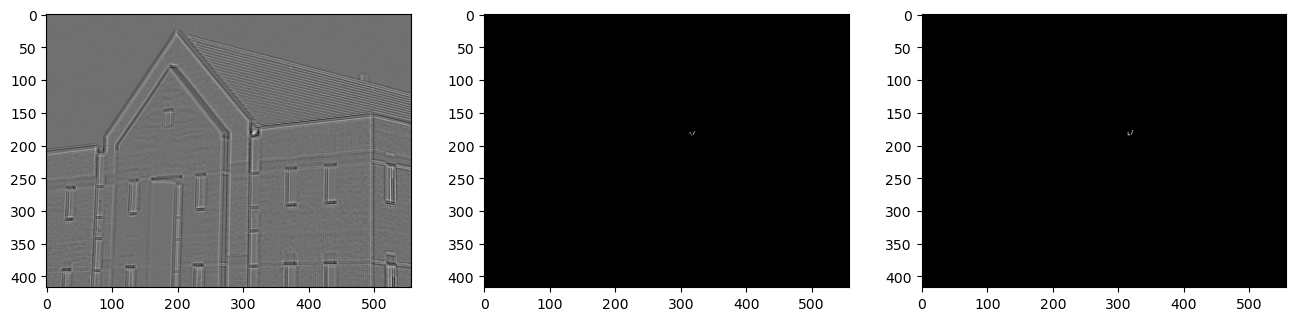

In [5]:
outImg, gNH = canny(houseLaplacian)
f, ax =plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(houseLaplacian, 'gray')
ax[1].imshow(gNH, 'gray')
ax[2].imshow(outImg, 'gray')

In [6]:
def filterSobel(img):
    Gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    Gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)

    M = np.hypot(Gx, Gy)
    alpha = np.arctan2(Gy, Gx)

    return (M, alpha)

In [7]:
def nonMax(alpha, M):
    height, width = M.shape
    gN = np.zeros((height, width), dtype=np.int32)

    angle = alpha * 180 / np.pi
    angle[angle < 0] += 180

    for i in range(1, height - 1):
      for j in range(1, width - 1):
        next = 255
        prev = 255

        #E-W
        if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
            next = M[i, j + 1]
            prev = M[i, j - 1]

        #NW-SE
        elif (22.5 <= angle[i, j] < 67.5):
            next = M[i + 1, j + 1]
            prev = M[i - 1, j - 1]

        #N-S
        elif (67.5 <= angle[i, j] < 112.5):
            next = M[i + 1, j]
            prev = M[i - 1, j]

        #NE-SW
        elif (112.5 <= angle[i, j] < 157.5):
            next = M[i - 1, j + 1]
            prev = M[i + 1, j - 1]


        if (M[i, j] >= next) and (M[i, j] >= prev):
            gN[i, j] = M[i, j]

    return gN

In [8]:
def threshold(img, lowThreshold, highThreshold):
    height, width = img.shape

    weak = np.int32(50)
    strong = np.int32(255)

    gNH = np.where(img >= highThreshold, strong, 0)
    gNL = np.where((img <= highThreshold) & (img >= lowThreshold), weak, 0)

    return (gNL, gNH, weak, strong)

In [9]:
def hysteresis(gNL, gNH, weak, strong):
  height, width = gNL.shape
  result = np.zeros((height, width), dtype=np.int32)
  visited = np.zeros((height, width), dtype=np.int32)

  iSure, jSure = np.where(gNH == strong)
  sureIndexes = list(zip(iSure, jSure))

  while sureIndexes:
    x, y = sureIndexes.pop()
    if visited[x, y]:
      continue

    visited[x, y] = 1
    result[x, y] = strong

    for i in range(x-1, x+2):
        for j in range(y-1, y+2):
          if gNL[i, j] == weak:
            result[i, j] = strong
            sureIndexes.append((i, j))

  return result

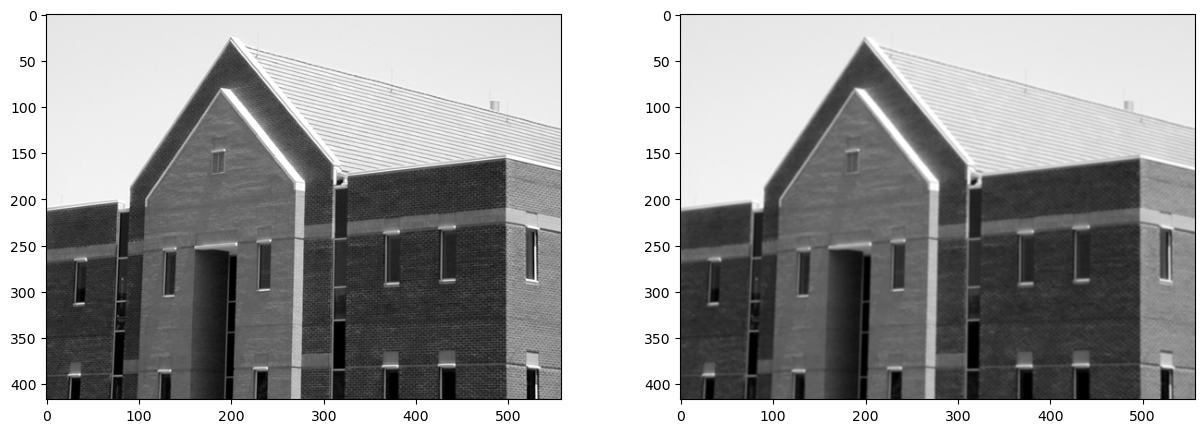

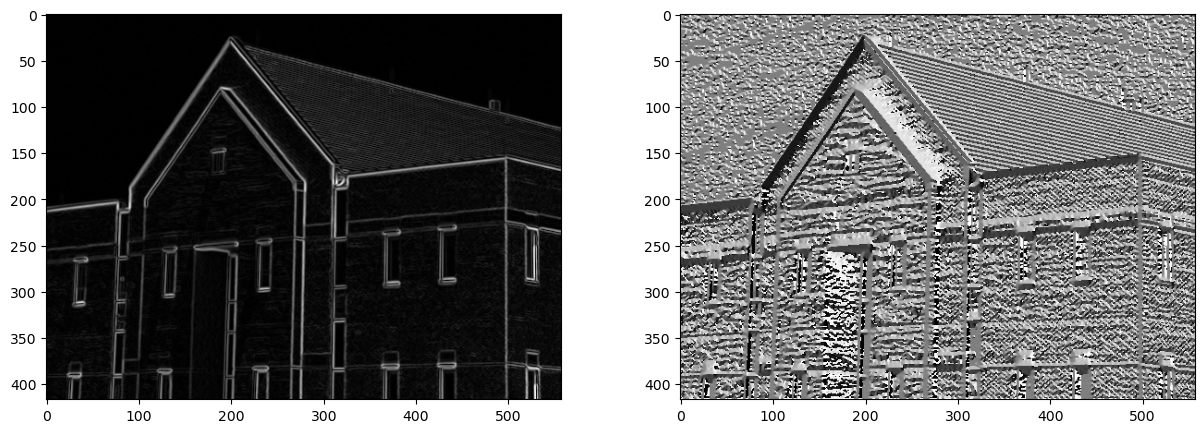

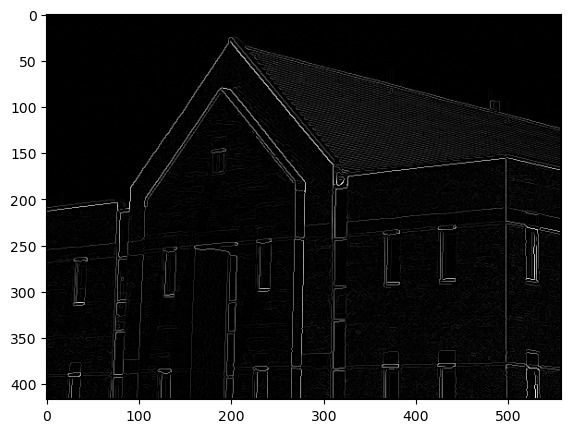

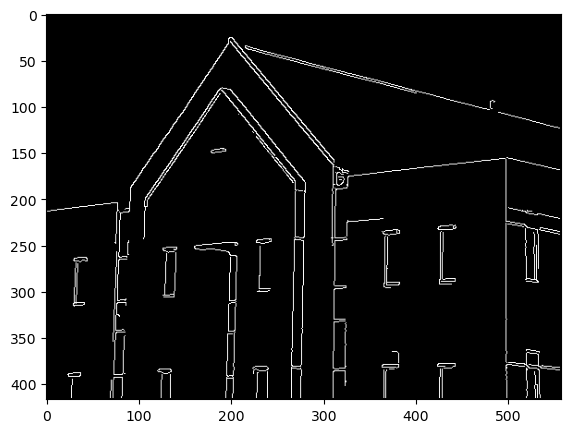

In [22]:
TH = 200
TL = 100
GAUSS = 3
SIGMA = 1

def canny(img):
    imgGauss = cv2.GaussianBlur(img, (GAUSS, GAUSS), SIGMA)
    plot(img, imgGauss)
    M, alpha = filterSobel(imgGauss)
    plot(M,alpha)
    gN = nonMax(alpha, M)
    plot(gN)
    gNL, gNH, weak, strong = threshold(gN, TL, TH)
    result = hysteresis(gNL, gNH, weak, strong)
    plot(result)
    return result, gNH

cannyImg, gNH = canny(house)





## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

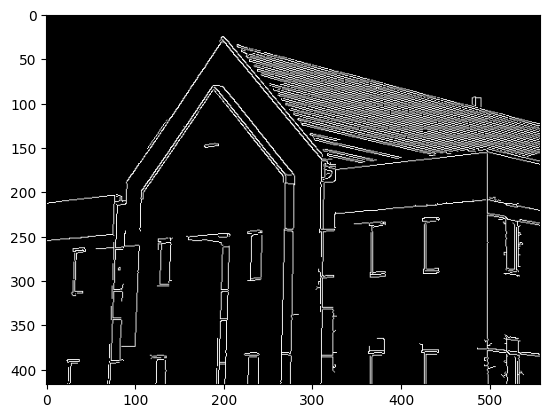

In [12]:
houseCanny = cv2.Canny(house, 100, 300, None, 3, 1)
plt.imshow(houseCanny, 'gray')